# SHAP Analysis for Fraud Detection Models

This notebook provides detailed SHAP (SHapley Additive exPlanations) analysis for our fraud detection models, helping us understand feature importance and model decisions.

## 1. Setup and Data Loading

In [1]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from pathlib import Path

# Set visualization style
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

def find_project_root(marker='.git'):
    current = Path(os.getcwd())
    while current != current.parent:
        if (current / marker).exists():
            return current
        current = current.parent
    return current

PROJECT_ROOT = find_project_root()

# Data Loading
data_path = PROJECT_ROOT / 'data' / 'processed' / 'processed_data.joblib'
feature_names_path = PROJECT_ROOT / 'data' / 'processed' / 'feature_names.joblib'

X_train, X_test, y_train, y_test = joblib.load(data_path)
feature_names = joblib.load(feature_names_path)

# Model Loading
models = {}
model_files = {
    'Random Forest': 'random_forest_model.joblib',
    'XGBoost': 'xgboost_model.joblib',
    'Logistic Regression': 'logistic_regression_model.joblib',
    'Isolation Forest': 'isolation_forest_model.joblib'
}

models_dir = PROJECT_ROOT / 'models'
for name, file in model_files.items():
    model_path = models_dir / file
    models[name] = joblib.load(model_path)

## 2. SHAP Analysis for Random Forest Model

In [4]:
# Initialize SHAP explainer for Random Forest
rf_model = models['Random Forest']
rf_explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values (using a sample for efficiency)
sample_idx = np.random.choice(X_test.index, size=500, replace=False)
X_sample = X_test.loc[sample_idx]
rf_shap_values = rf_explainer.shap_values(X_sample)

### 2.1 SHAP Summary Plot

<Figure size 1000x800 with 0 Axes>

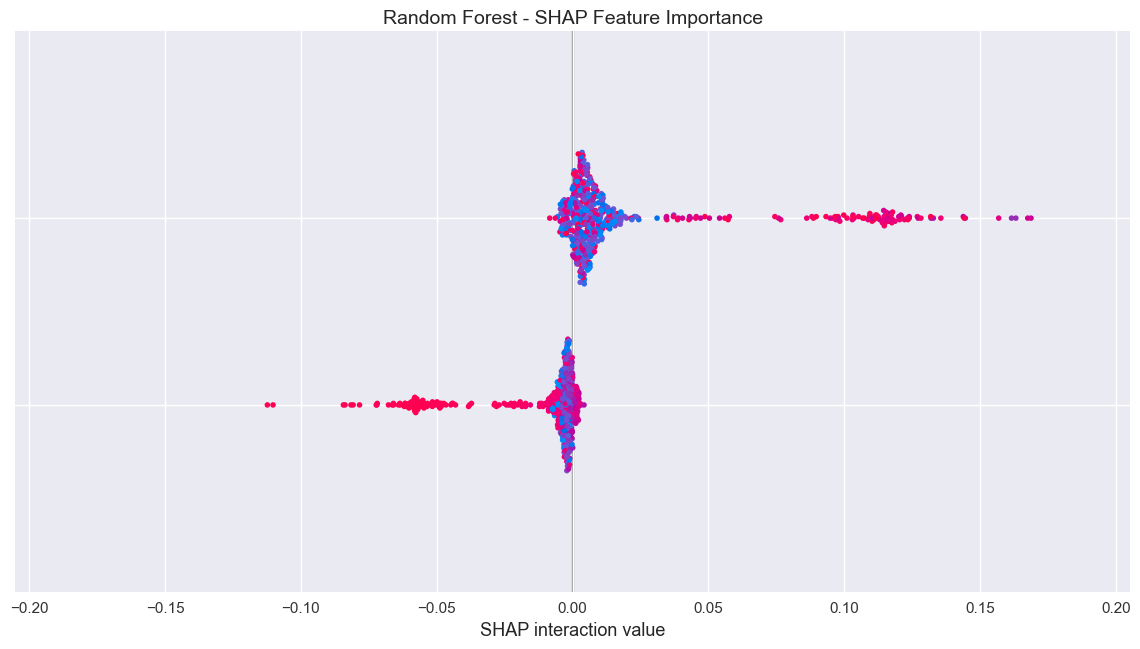

In [5]:
plt.figure(figsize=(10, 8))
shap.summary_plot(rf_shap_values, X_sample, feature_names=feature_names, show=False)
plt.title('Random Forest - SHAP Feature Importance', fontsize=14)
plt.tight_layout()
plt.savefig('../models/rf_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.2 SHAP Dependence Plots for Top Features

SHAP values shape: (500, 33, 2)
Class 1 SHAP values shape: (500, 33)
Top feature indices: [4, 14, 12, 10, 3]

Top 5 important features for fraud detection:
1. V4 (index: 4, mean |SHAP|: 0.0840)
2. V14 (index: 14, mean |SHAP|: 0.0840)
3. V12 (index: 12, mean |SHAP|: 0.0722)
4. V10 (index: 10, mean |SHAP|: 0.0492)
5. V3 (index: 3, mean |SHAP|: 0.0478)
Saved plot to /Users/chitransh/Financial-Fraud-Detection/models/rf_shap_dependence_V4.png


<Figure size 1000x600 with 0 Axes>

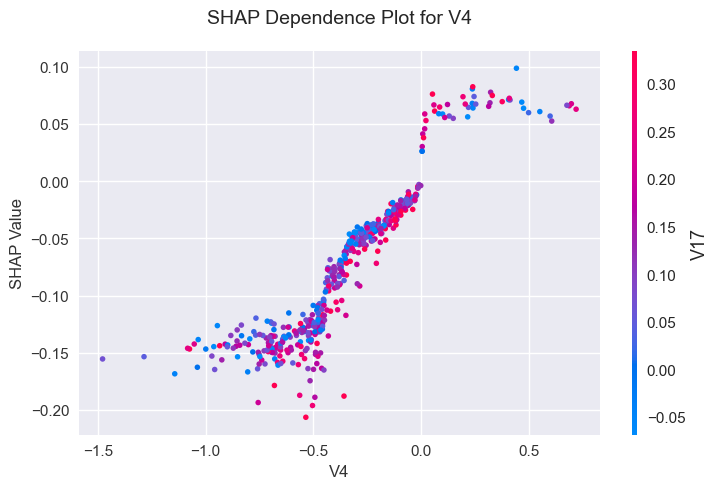

Saved plot to /Users/chitransh/Financial-Fraud-Detection/models/rf_shap_dependence_V14.png


<Figure size 1000x600 with 0 Axes>

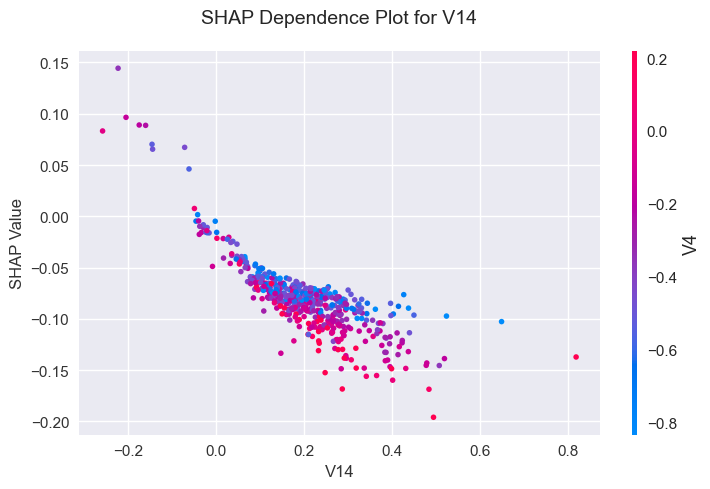

Saved plot to /Users/chitransh/Financial-Fraud-Detection/models/rf_shap_dependence_V12.png


<Figure size 1000x600 with 0 Axes>

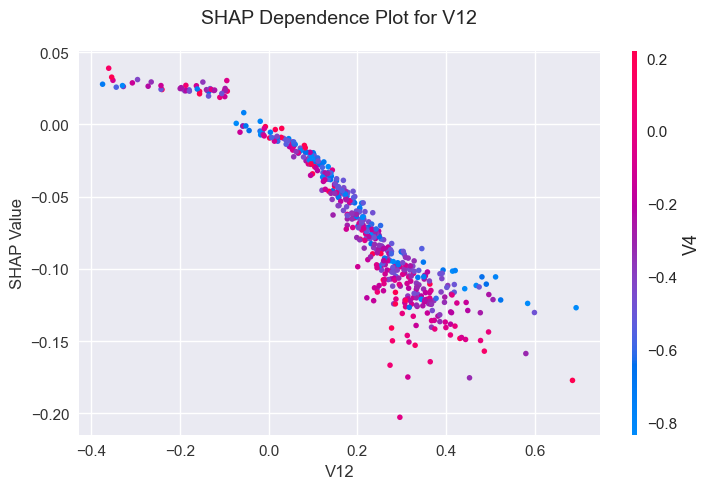

Saved plot to /Users/chitransh/Financial-Fraud-Detection/models/rf_shap_dependence_V10.png


<Figure size 1000x600 with 0 Axes>

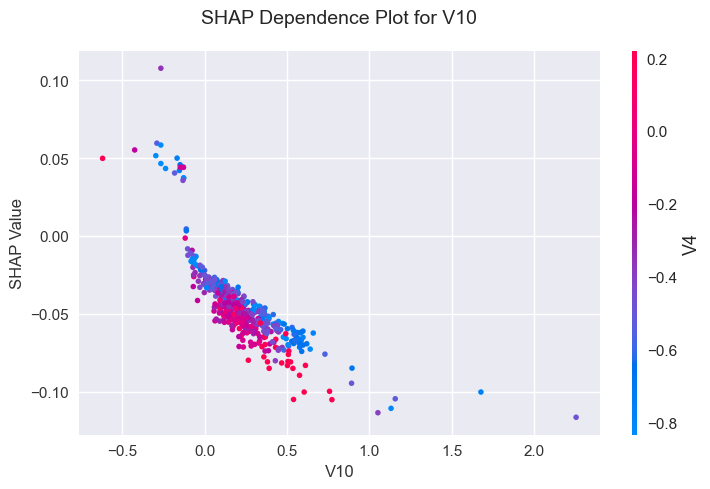

Saved plot to /Users/chitransh/Financial-Fraud-Detection/models/rf_shap_dependence_V3.png


<Figure size 1000x600 with 0 Axes>

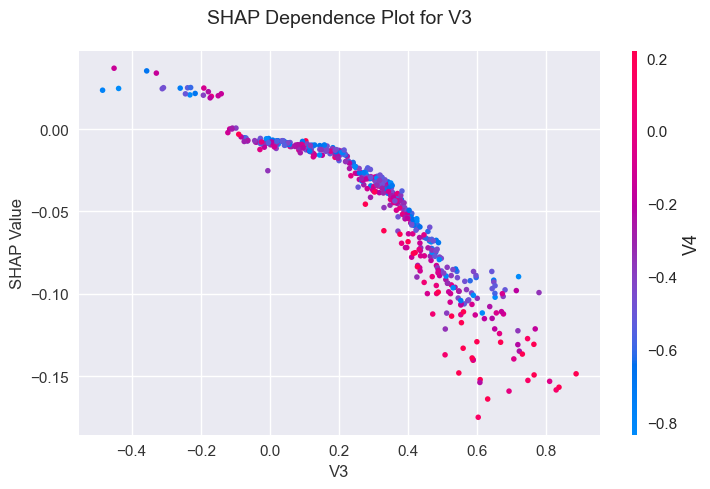

In [6]:
# Debug info shows we have 3D SHAP values (samples, features, classes)
print(f"SHAP values shape: {rf_shap_values.shape}")  # (500, 33, 2)

# For binary classification, we want SHAP values for class 1 (fraud)
shap_values = rf_shap_values[:, :, 1]  # Take only class 1 values
print(f"Class 1 SHAP values shape: {shap_values.shape}")  # Should be (500, 33)

# Calculate mean absolute SHAP values
shap_importances = np.abs(shap_values).mean(axis=0)

# Get indices of top 5 features
top_features_idx = np.argsort(shap_importances)[-5:][::-1]

# Convert to simple Python integers
top_features_idx = [int(i) for i in top_features_idx.flatten()]

print(f"Top feature indices: {top_features_idx}")

# Get feature names
top_features = [feature_names[i] for i in top_features_idx]

print("\nTop 5 important features for fraud detection:")
for i, (idx, feat) in enumerate(zip(top_features_idx, top_features), 1):
    print(f"{i}. {feat} (index: {idx}, mean |SHAP|: {shap_importances[idx]:.4f})")

# Create dependence plots
for i, (feature, idx) in enumerate(zip(top_features, top_features_idx)):
    plt.figure(figsize=(10, 6))
    
    shap.dependence_plot(
        idx,
        shap_values,
        X_sample,
        feature_names=feature_names,
        interaction_index='auto',
        show=False
    )
    
    plt.title(f'SHAP Dependence Plot for {feature}', fontsize=14, pad=20)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('SHAP Value', fontsize=12)
    plt.tight_layout()
    
    save_name = f"rf_shap_dependence_{feature.replace(' ', '_')}.png"
    save_path = PROJECT_ROOT / 'models' / save_name
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to {save_path}")
    plt.show()

### 2.3 SHAP Force Plot for Specific Cases

Using 50 fraud and 450 legitimate cases

Fraud Case Explanation:


<Figure size 1200x400 with 0 Axes>

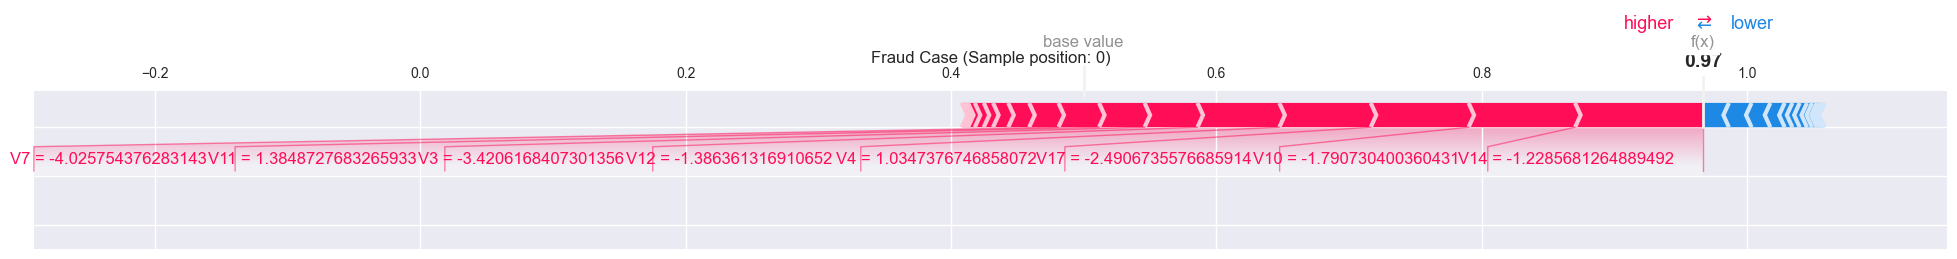


Legitimate Case Explanation:


<Figure size 1200x400 with 0 Axes>

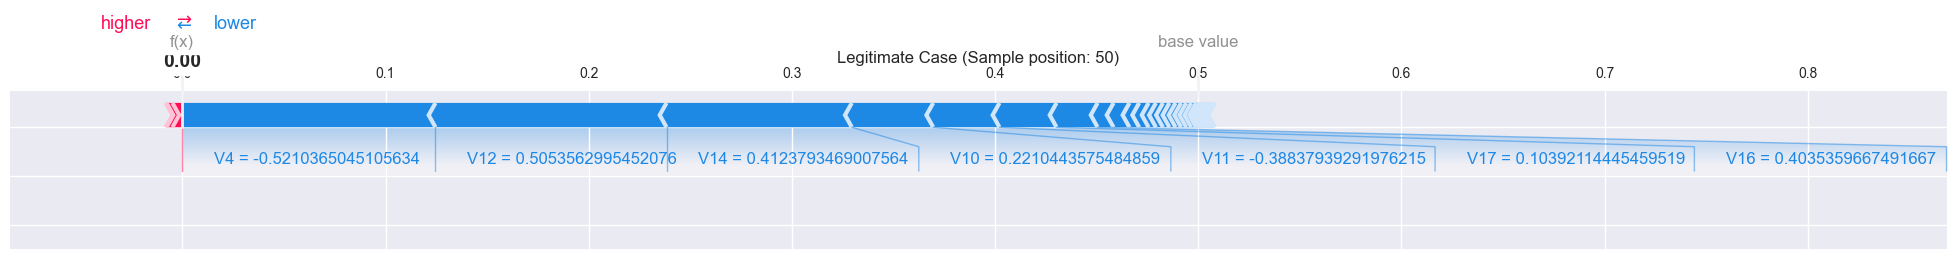

In [7]:
# First reset indices to ensure alignment
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Get indices of fraud and legitimate cases
fraud_indices = np.where(y_test_reset == 1)[0]
legit_indices = np.where(y_test_reset == 0)[0]

# Ensure we have both classes
if len(fraud_indices) == 0:
    raise ValueError("No fraud cases found in test set")
if len(legit_indices) == 0:
    raise ValueError("No legitimate cases found in test set")

# Sample separately from each class
n_fraud_sample = min(50, len(fraud_indices))  # Sample up to 50 fraud cases
n_legit_sample = min(450, len(legit_indices))  # Sample up to 450 legit cases

fraud_sample_idx = np.random.choice(fraud_indices, size=n_fraud_sample, replace=False)
legit_sample_idx = np.random.choice(legit_indices, size=n_legit_sample, replace=False)

# Combine samples
sample_indices = np.concatenate([fraud_sample_idx, legit_sample_idx])
X_sample = X_test_reset.iloc[sample_indices]

# Calculate SHAP values for this balanced sample
rf_shap_values = rf_explainer.shap_values(X_sample)
shap_values_class1 = rf_shap_values[:, :, 1]  # SHAP values for fraud class

# Get example cases (first from each class in our sample)
fraud_pos = 0  # First in sample is fraud
legit_pos = n_fraud_sample  # First legit case after fraud samples

# Generate force plots
print(f"Using {len(fraud_sample_idx)} fraud and {len(legit_sample_idx)} legitimate cases")

def create_and_show_force_plot(explainer, shap_values, features, feature_names, title, save_path):
    """Helper function to create, show, and save force plots"""
    plt.figure(figsize=(12, 4))
    shap.force_plot(
        explainer.expected_value[1],
        shap_values,
        features,
        feature_names=feature_names,
        matplotlib=True,
        show=False  # We'll handle showing manually
    )
    plt.title(title, fontsize=12, pad=20)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()  # This shows the plot we just created
    plt.close()  # Clean up

# Fraud case plot
print("\nFraud Case Explanation:")
create_and_show_force_plot(
    rf_explainer,
    shap_values_class1[fraud_pos],
    X_sample.iloc[fraud_pos],
    feature_names,
    f'Fraud Case (Sample position: {fraud_pos})',
    PROJECT_ROOT / 'models' / 'rf_shap_force_fraud.png'
)

# Legitimate case plot
print("\nLegitimate Case Explanation:")
create_and_show_force_plot(
    rf_explainer,
    shap_values_class1[legit_pos],
    X_sample.iloc[legit_pos],
    feature_names,
    f'Legitimate Case (Sample position: {legit_pos})',
    PROJECT_ROOT / 'models' / 'rf_shap_force_legit.png'
)

## 3. SHAP Analysis for XGBoost Model

In [8]:
# Initialize SHAP explainer for XGBoost
xgb_model = models['XGBoost']
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_sample)

### 3.1 SHAP Summary Plot

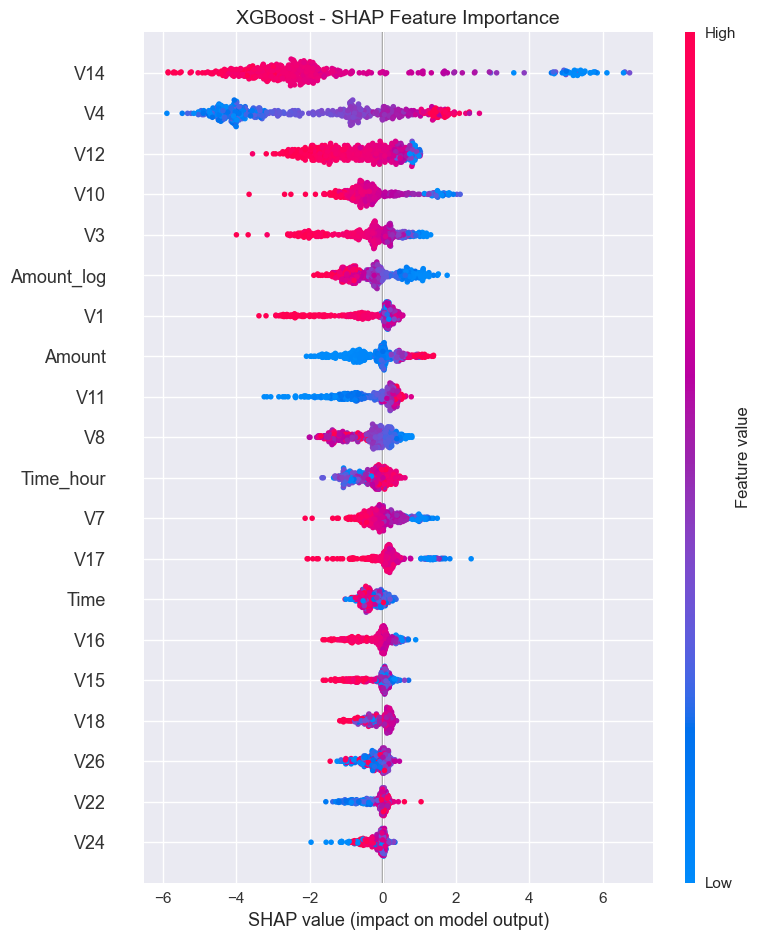

In [9]:
plt.figure(figsize=(10, 8))
shap.summary_plot(xgb_shap_values, X_sample, feature_names=feature_names, show=False)
plt.title('XGBoost - SHAP Feature Importance', fontsize=14)
plt.tight_layout()
plt.savefig('../models/xgb_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.2 SHAP Decision Plot

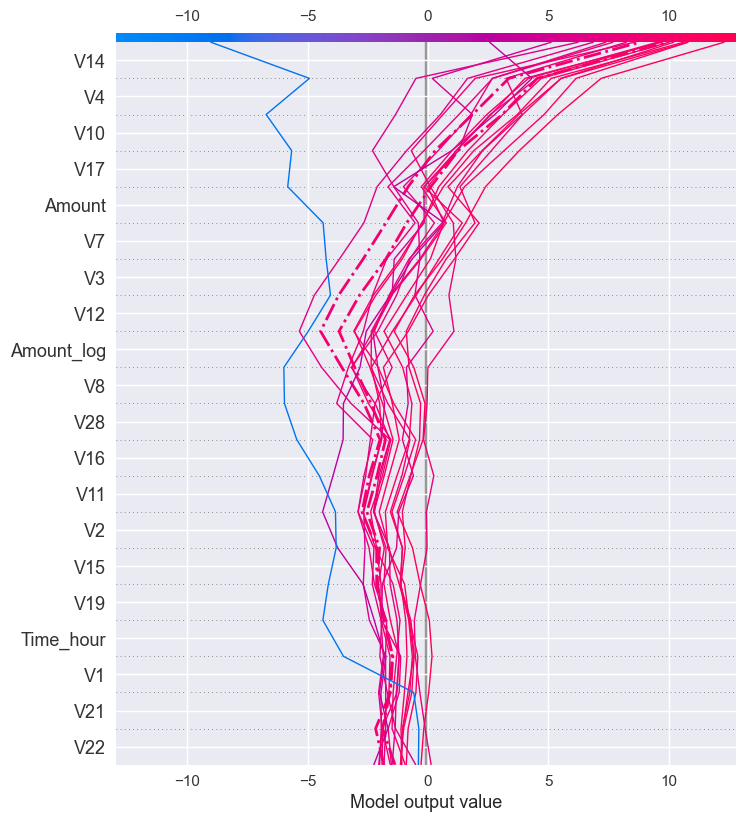

In [10]:
shap.decision_plot(
    xgb_explainer.expected_value,
    xgb_shap_values[:20],
    X_sample.iloc[:20],
    feature_names=feature_names,
    feature_order='importance',
    highlight=[0, 5]
)
plt.savefig(PROJECT_ROOT / 'models' / 'xgb_shap_decision.png', dpi=300, bbox_inches='tight')

## 4. SHAP Analysis for Logistic Regression

In [11]:
# Initialize SHAP explainer for Logistic Regression
lr_model = models['Logistic Regression']
lr_explainer = shap.LinearExplainer(lr_model, X_train)
lr_shap_values = lr_explainer.shap_values(X_sample)

### 4.1 SHAP Summary Plot

<Figure size 1000x600 with 0 Axes>

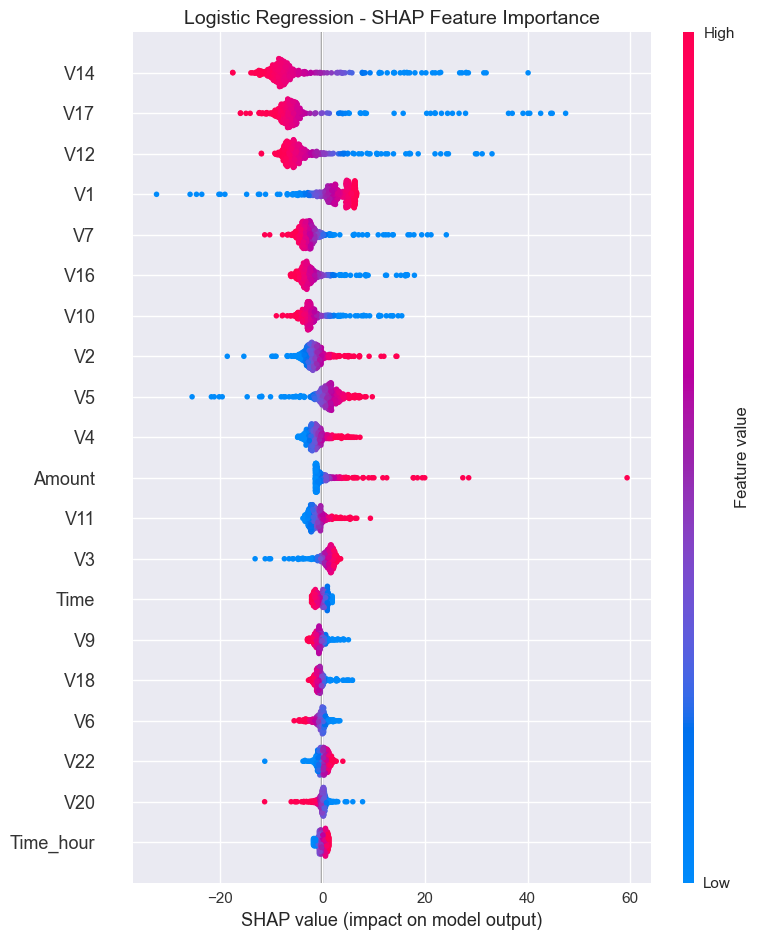

In [12]:
plt.figure(figsize=(10, 8))
shap.summary_plot(lr_shap_values, X_sample, feature_names=feature_names, show=False)
plt.title('Logistic Regression - SHAP Feature Importance', fontsize=14)
plt.tight_layout()
plt.savefig('../models/lr_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 SHAP Waterfall Plot

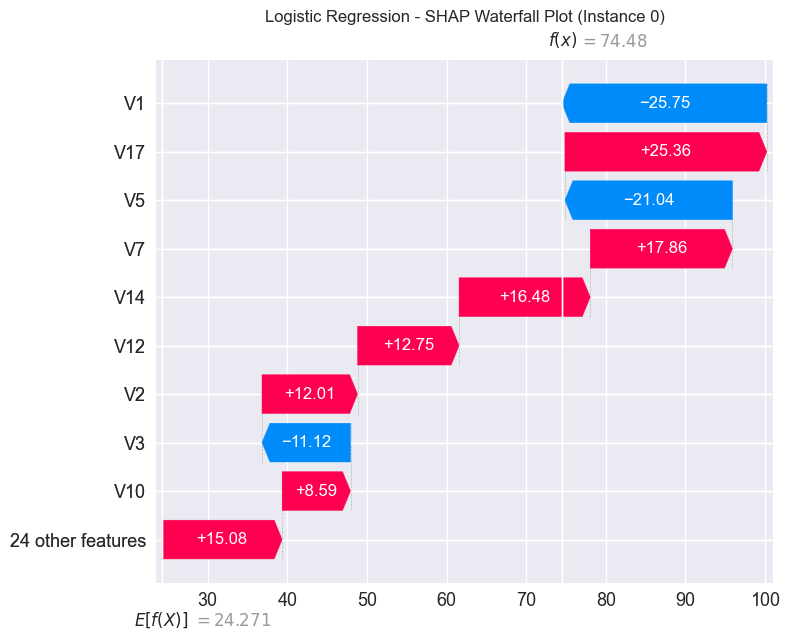

In [13]:
# Create the waterfall plot properly
instance_idx = 0

# Create figure explicitly
fig = plt.figure(figsize=(10, 6))

# Generate waterfall plot on our existing figure
shap.plots.waterfall(
    shap.Explanation(
        values=lr_shap_values[instance_idx],
        base_values=lr_explainer.expected_value,
        feature_names=feature_names
    ),
    max_display=10,
    show=False  # Important: prevent automatic figure creation
)

plt.title(f'Logistic Regression - SHAP Waterfall Plot (Instance {instance_idx})', fontsize=12)
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'models' / 'lr_shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. SHAP Analysis for Isolation Forest

In [14]:
# Initialize SHAP explainer for Isolation Forest
iso_model = models['Isolation Forest']

# Create wrapper function for anomaly scores
def iso_predict(x):
    return -iso_model.decision_function(x)  # Convert to positive anomaly scores

# Use Kernel SHAP for model-agnostic explanation
background = shap.sample(X_train, 100)
iso_explainer = shap.KernelExplainer(iso_predict, background)
iso_shap_values = iso_explainer.shap_values(X_sample.iloc[:50])  # Smaller sample for efficiency

/Users/chitransh/Financial-Fraud-Detection/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/chitransh/Financial-Fraud-Detection/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/chitransh/Financial-Fraud-Detection/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/chitransh/Financial-Fraud-Detection/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/chitransh/Financial-Fraud-Detection/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/chitransh/Financial-Fraud-Detection/venv/lib/python3.11/site-packages/sklearn/uti

### 5.1 SHAP Summary Plot for Anomaly Scores

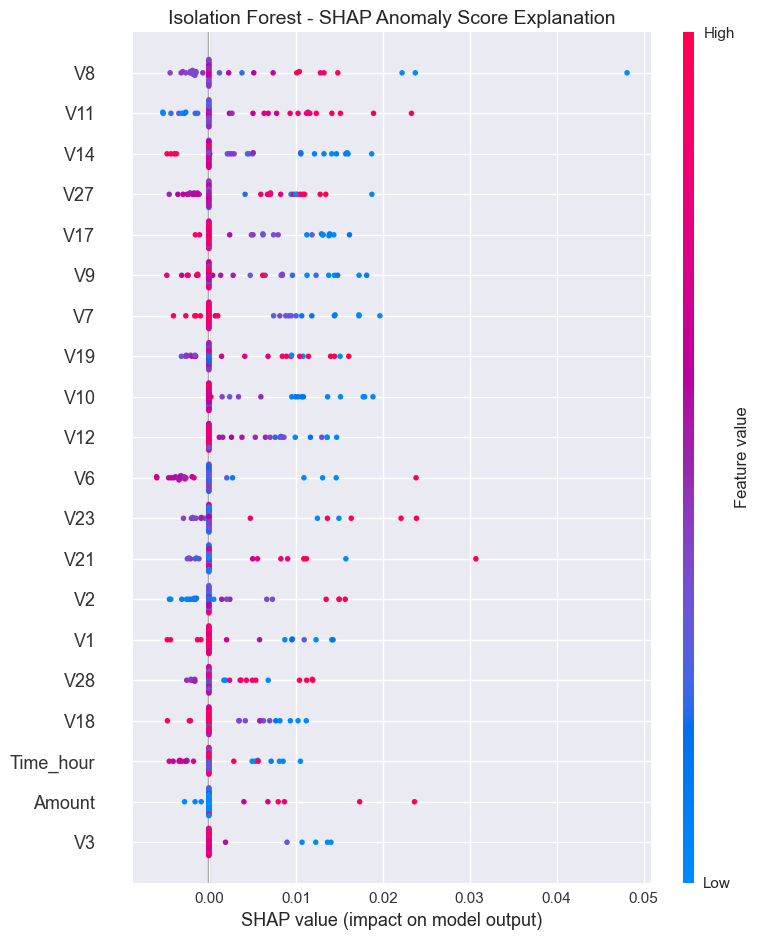

In [15]:
plt.figure(figsize=(10, 8))
shap.summary_plot(iso_shap_values, X_sample.iloc[:50], feature_names=feature_names, show=False)
plt.title('Isolation Forest - SHAP Anomaly Score Explanation', fontsize=14)
plt.tight_layout()
plt.savefig('../models/iso_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Comparative Analysis Across Models

In [16]:
def get_top_shap_features(shap_values, n=5):
    """Get top n features by mean absolute SHAP value"""
    # Handle different SHAP value formats
    if isinstance(shap_values, list):
        # For binary classification, use class 1 (typically fraud)
        if len(shap_values) == 2:
            shap_array = shap_values[1]  # Use fraud class SHAP values
        else:
            shap_array = shap_values[0]
    else:
        shap_array = shap_values
    
    # Ensure we have 2D array (samples × features)
    if shap_array.ndim == 3:
        shap_array = shap_array[:, :, 0]  # Take first class if 3D
    
    # Calculate mean absolute SHAP values
    mean_abs_shap = np.mean(np.abs(shap_array), axis=0)
    
    # Get top indices and feature names
    top_idx = np.argsort(mean_abs_shap)[-n:][::-1]
    return [feature_names[int(i)] for i in top_idx]  # Explicit int conversion

# Get top features for each model with error handling
top_features = {}
models = {
    'Random Forest': rf_shap_values,
    'XGBoost': xgb_shap_values,
    'Logistic Regression': lr_shap_values,
    'Isolation Forest': iso_shap_values
}

for name, values in models.items():
    try:
        top_features[name] = get_top_shap_features(values)
    except Exception as e:
        print(f"Error processing {name}: {str(e)}")
        top_features[name] = ["N/A"] * 5  # Placeholder if error occurs

# Create and display comparison table
comparison_df = pd.DataFrame(top_features)
print("Top 5 Most Important Features by Model:")
comparison_df

Top 5 Most Important Features by Model:


,Random Forest,XGBoost,Logistic Regression,Isolation Forest
0,V14,V14,V14,V8
1,V4,V4,V17,V11
2,V12,V12,V12,V14
3,V10,V10,V1,V27
4,V3,V3,V7,V17


## 7. Saving Results

In [ ]:
# Save SHAP values for later use
shap_results = {
    'Random Forest': rf_shap_values,
    'XGBoost': xgb_shap_values,
    'Logistic Regression': lr_shap_values,
    'Isolation Forest': iso_shap_values
}

joblib.dump(shap_results, '../models/all_shap_values.joblib')
joblib.dump(comparison_df, '../models/shap_feature_comparison.joblib')

print("SHAP analysis results saved successfully.")

SHAP analysis results saved successfully.
